### Predicting hand written integers using scikit learn

In [44]:
### the dataset can be downloaded from sklearn 
#from sklearn.datasets import fetch_openml
#mnist = fetch_openml('mnist_784', version=1)

# I downloaded the dataset on my local dir
import pandas as pd

mnist_csv = open("mnist-in-csv/mnist_train.csv", "r")
mnist_df = pd.read_csv(mnist_csv)

mnist_test = open("mnist-in-csv/mnist_test.csv", "r")
mnist_test_df = pd.read_csv(mnist_test)

mnist_df.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
X = mnist_df.drop("label", axis=1)
y = mnist_df['label']

X_tst = mnist_test_df.drop("label", axis=1)
y_tst = mnist_test_df['label']

X.shape
y.shape

(60000,)

### Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28 × 28 array, and display it using Matplotlib’s imshow() function.

In [64]:
print(X.loc[0])
print(y[0])

1x1      0
1x2      0
1x3      0
1x4      0
1x5      0
        ..
28x24    0
28x25    0
28x26    0
28x27    0
28x28    0
Name: 0, Length: 784, dtype: int64
5


### Visualizing an Integer
Selecting an integer in the DataFrame and converting it in to NumPy array to apply reshape() on it.

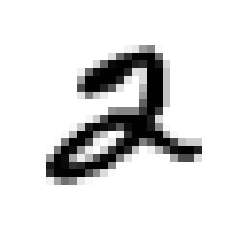

In [60]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

some_digit = X.loc[5].to_numpy()
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [62]:
X_train, X_test, y_train, y_test = X, X_tst, y, y_tst

### A Binary Classifier
will treat the instances of 5 as positive and all other digits as negative class.

In [65]:
y_train_5 = (y_train == 5)  # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

### Applying Stochastic Gradient Descent 

In [66]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

NameError: name 'y_train_5' is not defined

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

NameError: name 'y_train_5' is not defined

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    [...] # Add axis labels and grid

plot_roc_curve(fpr, tpr)
plt.show()

NameError: name 'fpr' is not defined